In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)
print(pd.__version__)

0.25.3


/home/miguel/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/miguel/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [3]:
def get_Dataframe(path, name='Data', tag=None):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        if( df is not None):
            if(df.shape[0]>5000000): continue
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["Q2*","gen_Q2","y*","HFS*",'gen_y',"e_*","gene*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["Q2*","y*","e_*","HFS*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    if( not(df is None)):
        print('Dataframe has a total of ', df.shape[0], ' entries')
    else:
        print ('Dataframe has no entry, it is None')
    print('####################################################################')

    return df


In [4]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [6]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('logQ2_e= log(Q2_e)/2.3025850', inplace=True)
    temp.eval('logQ2_esigma= log(Q2_esigma)/2.3025850', inplace=True)
    temp.eval('logQ2_sigma= log(Q2_sigma)/2.3025850', inplace=True)
    temp.eval('logQ2_da= log(Q2_da)/2.3025850', inplace=True)

    temp.eval('s = 4*27.6*920', inplace=True)
    temp.eval('x_e = Q2_e/(s*y_e)',inplace=True)
    temp.eval('x_da = Q2_da/(s*y_da)',inplace=True)
    temp.eval('x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
    temp.eval('x_esigma = x_sigma',inplace=True)


    temp = applyCut(temp, 'pass_reco==0 | ptmiss < 10', 'ptmiss<10')

    #temp = applyCut(temp, 'pass_reco==0 | 0.08 < y_e < 0.7', '0.08 < y_e < 0.7')
    #temp = applyCut(temp, 'pass_reco==0 | Q2_e>150', 'Q2_e>150')
    temp = applyCut(temp, 'pass_reco==0 | Empz<65', 'Empz<65')
    temp = applyCut(temp, 'pass_reco==0 | Empz>45', 'Empz>45')
   
    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')
        temp = applyCut(temp,'gen_Q2>150',' gen_Q2>150')
        temp.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        
        temp.eval('yda_ratio = y_da/gen_y',inplace=True)
        temp.eval('ysigma_ratio = y_sigma/gen_y',inplace=True)
        temp.eval('yesigma_ratio = y_esigma/gen_y',inplace=True)
        temp.eval('ye_ratio = y_e/gen_y',inplace=True)
        
        temp.eval('Q2e_ratio = Q2_e/gen_Q2',inplace=True)
        temp.eval('Q2da_ratio = Q2_da/gen_Q2',inplace=True)
        temp.eval('Q2sigma_ratio = Q2_sigma/gen_Q2',inplace=True)
        temp.eval('Q2esigma_ratio = Q2_esigma/gen_Q2',inplace=True)
        
        temp.eval('xe_ratio = x_e/gen_x',inplace=True)
        temp.eval('xda_ratio = x_da/gen_x',inplace=True)
        temp.eval('xsigma_ratio = x_sigma/gen_x',inplace=True)
        temp.eval('xesigma_ratio = x_esigma/gen_x',inplace=True)
        
        

    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

In [7]:
mc_name = 'Django'
altmc_name = 'Rapgap'
path ='/home/miguel/calostudies/forDNN/out_ep0607/'
mc_tag = 'nominal'

In [8]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag)


filename is /home/miguel/calostudies/forDNN/out_ep0607/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Django_Eplus0607_134.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Django_Eplus0607_13.nominal.root
[b'Django;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Django_Eplus0607_121.nominal.root
[b'Django;1']
####################################################################
Dataframe has a total of  5957479  entries
####################################################################
CPU times: user 2.91 s, sys: 394 ms, total: 3.31 s
Wall time: 3.3 s


In [9]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag)

filename is /home/miguel/calostudies/forDNN/out_ep0607/Rapgap_Eplus0607_116.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Rapgap_Eplus0607_8.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Rapgap_Eplus0607_101.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Rapgap_Eplus0607_107.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Rapgap_Eplus0607_131.nominal.root
[b'Rapgap;1']
filename is /home/miguel/calostudies/forDNN/out_ep0607/Rapgap_Eplus0607_103.nominal.root
[b'Rapgap;1']
####################################################################
Dataframe has a total of  5949332  entries
####################################################################
CPU times: user 2.93 s, sys: 322 ms, total: 3.25 s
Wall time: 3.25 s


In [10]:
mc.keys()

Index(['Q2_e', 'Q2_sigma', 'Q2_esigma', 'Q2_da', 'gen_Q2', 'y_e', 'y_sigma',
       'y_esigma', 'y_da', 'HFS_px', 'HFS_py', 'HFS_pz', 'gen_y', 'e_px',
       'e_py', 'e_pz', 'gene_px', 'gene_py', 'gene_pz', 'wgt', 'vertex_z',
       'ptmiss', 'ptratio_da', 'ptratio_ele', 'Empz', 'pth'],
      dtype='object')

In [11]:
%%time 
mc['pass_reco'] = np.where(mc['Q2_e']>0, 1, 0)
mc['pass_truth'] = np.where(mc['gen_Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['Q2_e']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['gen_Q2']>0, 1, 0)


CPU times: user 44.5 ms, sys: 40.3 ms, total: 84.7 ms
Wall time: 84.4 ms


In [14]:
%%time 
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)

Selecting MC events

ptmiss<10 2840590  fraction kept: 100.0
Empz<65 2840590  fraction kept: 100.0
Empz>45 2840590  fraction kept: 100.0
 pass_truth>0 2840590  fraction kept: 100.0
 gen_Q2>150 2840590  fraction kept: 100.0
Selecting MC events

ptmiss<10 3034143  fraction kept: 100.0
Empz<65 3034143  fraction kept: 100.0
Empz>45 3034143  fraction kept: 100.0
 pass_truth>0 3034143  fraction kept: 100.0
 gen_Q2>150 3034143  fraction kept: 100.0
CPU times: user 3.03 s, sys: 607 ms, total: 3.64 s
Wall time: 2.69 s


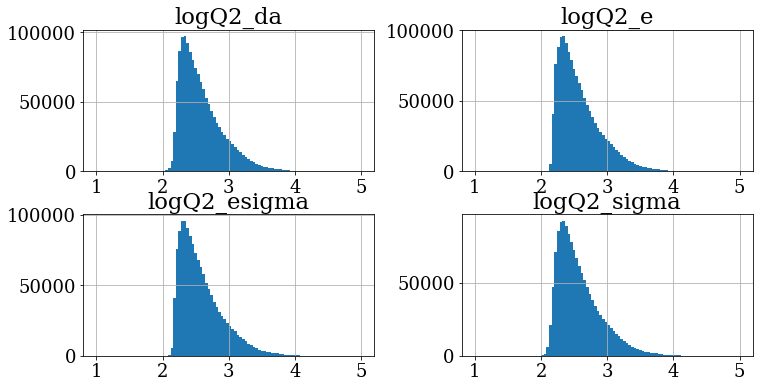

In [13]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['logQ2_e','logQ2_da','logQ2_sigma','logQ2_esigma'],range=(1,5))
plt.show()

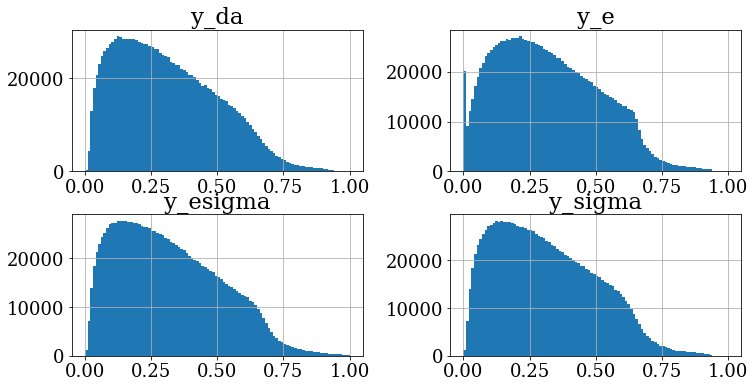

In [15]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['y_e','y_da','y_sigma','y_esigma'],range=(0,1))
plt.show()

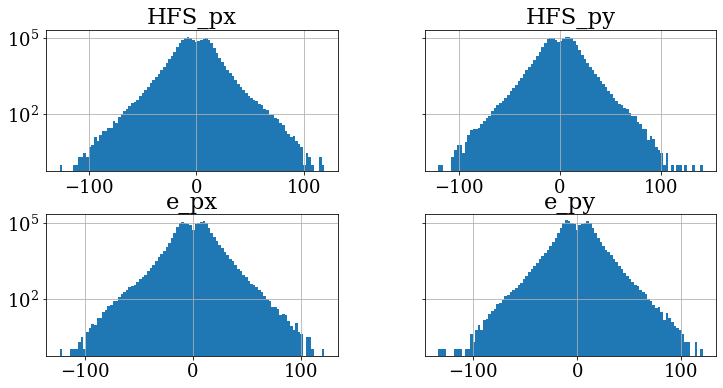

In [16]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['HFS_px','HFS_py','e_px','e_py'],sharey=True)
plt.yscale('log')

plt.show()

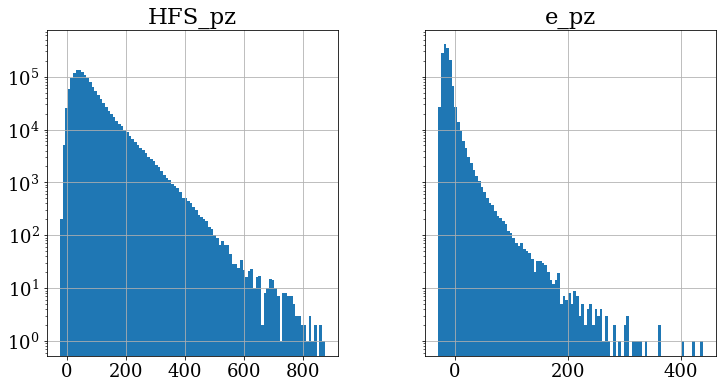

In [17]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['HFS_pz','e_pz'],sharey=True)
plt.yscale('log')
plt.show()

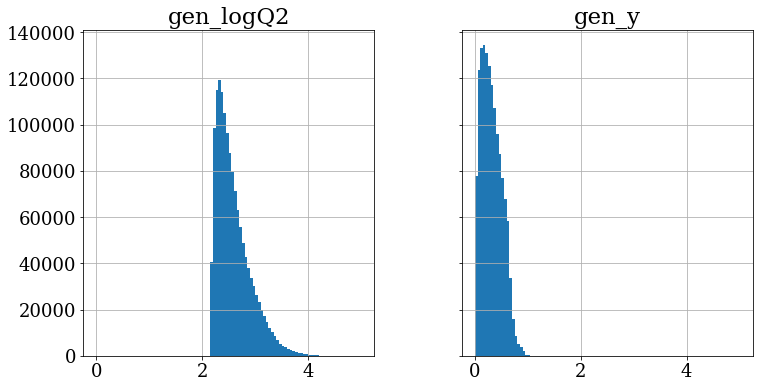

In [18]:
mc.query('pass_reco>0').hist(figsize=(12,6),bins=100,column=['gen_logQ2','gen_y'],range=(0,5),sharey=True)
plt.show()

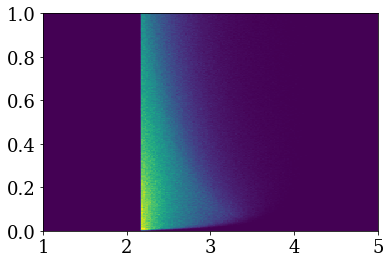

In [19]:
plt.hist2d(mc['gen_logQ2'],mc['gen_y'],range=([1,5],[0,1]),bins=200)
plt.show()

In [ ]:
mc.eval('yda_ratio = y_da/gen_y',inplace=True)
mc.eval('ysigma_ratio = y_sigma/gen_y',inplace=True)
mc.eval('yesigma_ratio = y_esigma/gen_y',inplace=True)
mc.eval('ye_ratio = y_e/gen_y',inplace=True)


mc.eval('Q2da_ratio = Q2_da/gen_Q2',inplace=True)
mc.eval('Q2sigma_ratio = Q2_sigma/gen_Q2',inplace=True)
mc.eval('Q2esigma_ratio = Q2_esigma/gen_Q2',inplace=True)

mc.eval('Q2e_ratio = Q2_e/gen_Q2',inplace=True)


['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


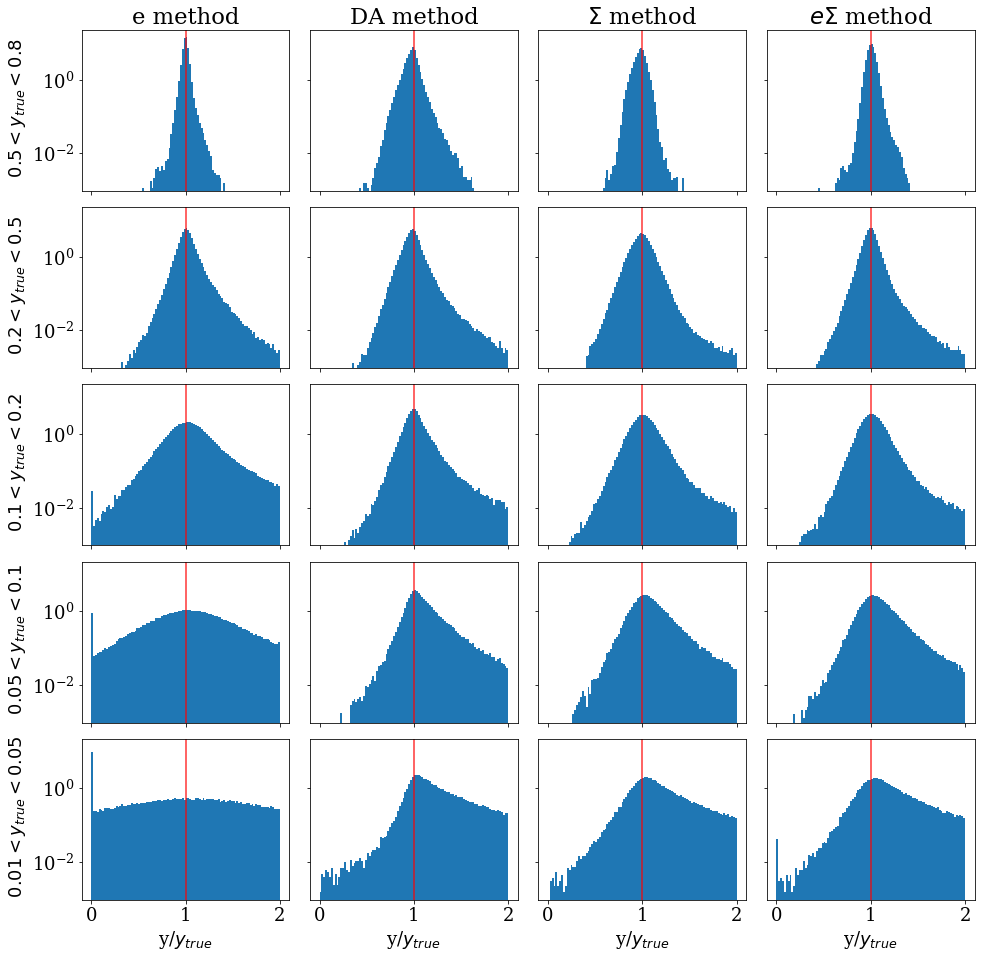

In [20]:
fig,ax = plt.subplots(5,4,figsize=(16,16),sharey=True,sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['ye_ratio'],density=True,bins=100,range=(0,2),label='e method')
    ax[1 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['yda_ratio'],density=True,bins=100,range=(0,2),label='DA method')
    ax[2 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['ysigma_ratio'],density=True,bins=100,range=(0,2),label='$\Sigma$ method')
    ax[3 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['yesigma_ratio'],density=True,bins=100,range=(0,2),label='$e-\Sigma$ method')

for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[0].set_title('e method')
ax[1].set_title('DA method')
ax[2].set_title('$\Sigma$ method')
ax[3].set_title('$e\Sigma$ method')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'y/$y_{true}$ ')

ax[-2].set_xlabel(r'y/$y_{true}$ ')
ax[-3].set_xlabel(r'y/$y_{true}$ ')
ax[-4].set_xlabel(r'y/$y_{true}$ ')


plt.show()

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


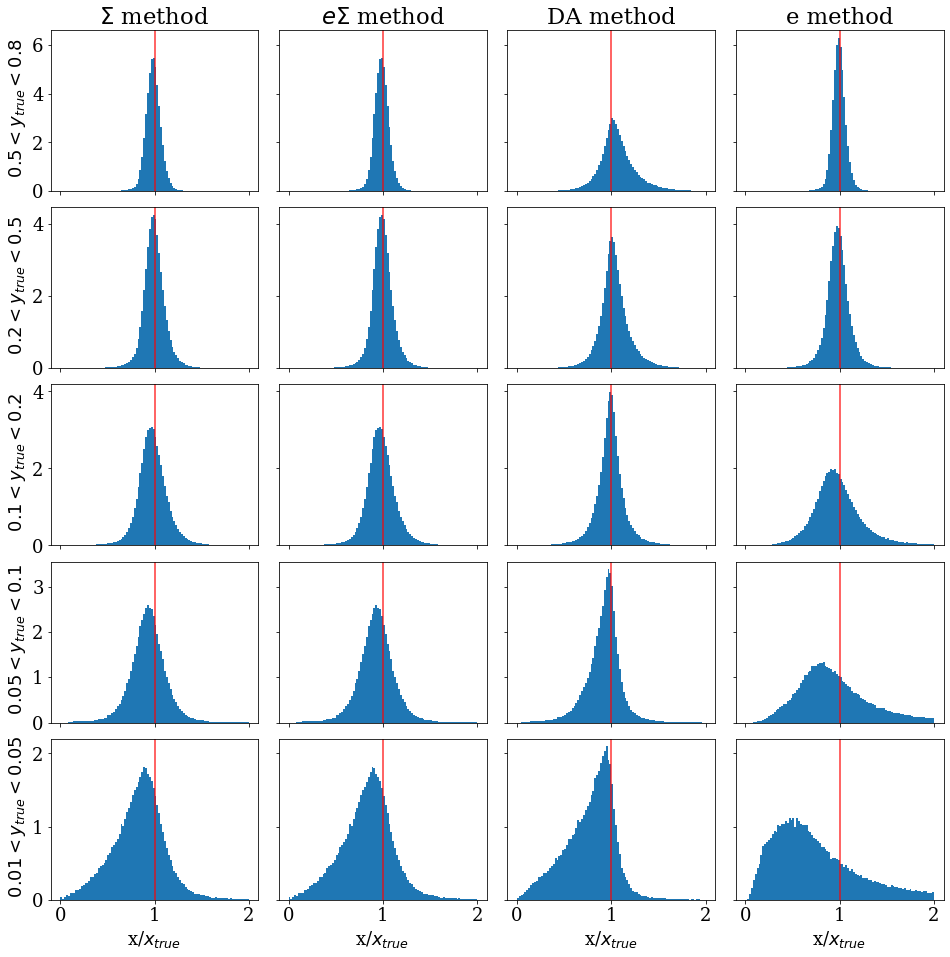

In [28]:
fig,ax = plt.subplots(5,4,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 4*i].hist(mc.query(ybins[i] + ' and pass_reco>0')['xsigma_ratio'],density=True,bins=100,range=(0,2))
    ax[1 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xesigma_ratio'],density=True,bins=100,range=(0,2))
    ax[2 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xda_ratio'],density=True,bins=100,range=(0,2))
    ax[3 + 4*i].hist(mc.query(ybins[i]+ ' and pass_reco>0')['xe_ratio'],density=True,bins=100,range=(0,2))

for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()